# Benchmark test of Marimo

In this notebook, we compare the results of Marimo and RADMC-3D using the same physical models.

The implementation of the continuum is different, therefore, the following test calculation is done without contiuum disk.

## 1. setting the disk model

In [168]:
import sys
sys.path.append('/export/tom/project/handmade_modules/iwashi/iwashi')
import numpy as np
import matplotlib.pyplot as plt
import iwashi
import astropy.constants as cst

# constants

au = cst.au.cgs.value
G = cst.G.cgs.value
c = cst.c.cgs.value
h = cst.h.cgs.value
M_sun = cst.M_sun.cgs.value
m_p = cst.m_p.cgs.value
k_B = cst.k_B.cgs.value
sigma_sb = cst.sigma_sb.cgs.value
L_sun = cst.L_sun.cgs.value
mu_gas = 2.37

# disk parameters

rcav = 0.01*au
dcav = 1.0

r0 = 5*au
rin = rcav

M_star = 1.0 * M_sun

Tmid0 = 50
pmid = 0.5

incl = 30.0
pa = 150.0

rout = 10*au
rexp = 3*au


Nco_0 = 1e26
Xco = 1e-8
patm = 0.5
Tatm0 = 200
Nco_g = 0.0

D = 150.0

# dust

k_d = 1.0

# calc setting

Rmax = 12*au
Rmin = 0.01*au

nthreads = 32

V = np.linspace(-5, 5, 100)*1e5

Nx = 256

## 2. calculation with Marimo

In [169]:
calc =  iwashi.calc_config(
                    line_files = ['co.dat'],
                    line_levels = [2], 
                    incl = incl,
                    pa = pa,
                    D = D,
                    V = V, 
                    Rmin = Rmin,
                    xmax = Rmax,
                    Nx = Nx,
                    subpix_max = 128,
                    subpix_pow = 1.0,
                    nz = 200,
                    z2r = 0.5, 
                    voigt = False, 
                    dust = False,
                    contsub = True, 
                    kind = 1,
                    nthreads = nthreads)


disk = iwashi.disk_config(
                    r0 = r0, 
                    rin = rin,
                    rout = rout,
                    rexp = rexp,
                    rcav = rcav,
                    dcav = dcav,
                    d2g = 1/100,
                    chi_d = 0.0,
                    k_d = k_d,
                    Nco_0 = Nco_0, 
                    Nco_g = Nco_g, 
                    Tmid0 = Tmid0, 
                    Tatm0 = Tatm0, 
                    pmid = pmid, 
                    patm = patm, 
                    Xco = Xco,
                    vturb = 0.0,
                    Mstar = M_star)

In [170]:
results = iwashi.run(disk, calc)

9/10 🍢🍢🍢🍢🍢🍢🍢🍢🍢  

## 3. calculation with RADMC-3D

In [171]:
# problem_setup
directry = './radmc_model/'


#
# Import NumPy for array handling
#
import numpy as np
#
# Import plotting libraries (start Python with ipython --matplotlib)
#
#from mpl_toolkits.mplot3d import axes3d
#from matplotlib import pyplot as plt
#
# Some natural constants
#
au  = 1.49598e13     # Astronomical Unit       [cm]
pc  = 3.08572e18     # Parsec                  [cm]
ms  = 1.98892e33     # Solar mass              [g]
ts  = 5.78e3         # Solar temperature       [K]
ls  = 3.8525e33      # Solar luminosity        [erg/s]
rs  = 6.96e10        # Solar radius            [cm]
GG  = 6.67408e-08    # Gravitational constant  [cm^3/g/s^2]
mp  = 1.6726e-24     # Mass of proton          [g]

kB = 1.380649e-16
mu_gas = 2.37

#
# Grid parameters
#
nr       = 400
ntheta   = 200
nphi     = 1
rin      = 0.01*au
thetaup  = np.pi*0.5 - 1.0e0

#
# Star parameters
#
mstar    = 1.0*ms
rstar    = rs
tstar    = ts
pstar    = np.array([0.,0.,0.])


#
# Make the coordinates
#
ri       = np.logspace(np.log10(rin),np.log10(rout),nr+1)
thetai   = np.linspace(thetaup, 0.5e0*np.pi, ntheta+1)
phii     = np.linspace(0.e0,np.pi*2.e0,nphi+1)
rc       = 0.5 * ( ri[0:nr] + ri[1:nr+1] )
thetac   = 0.5 * ( thetai[0:ntheta] + thetai[1:ntheta+1] )
phic     = 0.5 * ( phii[0:nphi] + phii[1:nphi+1] )

#
# Make the grid
#
qq       = np.meshgrid(rc,thetac,phic,indexing='ij')
rr       = qq[0]
tt       = qq[1]
zr       = np.pi/2.e0 - qq[1]

R = rr*np.sin( tt )
Z = rr*np.cos( tt )
T = tt


Tmid = Tmid0 * ( R/r0 )**(-pmid)
Tatm = Tatm0 * ( R/r0 )**(-patm)

# Andrews+12
hg = np.sqrt( kB * Tmid * R**3 / ( mu_gas * mp * GG * mstar ) )

l1 = 1.0
l2 = 4.0

Tgas = Tmid * ( Z < l1 * hg ) + ( Tmid + (Tatm - Tmid)*(Z-l1*hg) / (l2-l1) / hg )*( Z < l2 * hg ) *( Z >= l1 * hg ) + Tatm * ( Z >= l2 * hg )

N = Nco_0 * ( R/r0 )**(-Nco_g) * np.exp( -( R/rexp )**(2.0-Nco_g)) * ( R < rout)

#
# Make the gas density model
#


nco = N / (np.sqrt(2*np.pi) * hg) * np.exp( -0.5*( Z/hg  )**2  )

nh2 = nco / Xco


#
# Make the velocity model
#
vr       = np.zeros_like(R)
vtheta   = np.zeros_like(R)
vphi     = np.sqrt(GG*mstar/R)
#vturb    = 0.1*vphi

a_turb = 0.0
vturb    = np.full_like(R, a_turb*1e5)


#
# Write the wavelength_micron.inp file
lam1     = 0.1e0
lam2     = 7.0e0
lam3     = 25.e0
lam4     = 1.0e4
n12      = 20
n23      = 100
n34      = 30
lam12    = np.logspace(np.log10(lam1),np.log10(lam2),n12,endpoint=False)
lam23    = np.logspace(np.log10(lam2),np.log10(lam3),n23,endpoint=False)
lam34    = np.logspace(np.log10(lam3),np.log10(lam4),n34,endpoint=True)
lam      = np.concatenate([lam12,lam23,lam34])
nlam     = lam.size

#
# Write the wavelength file
#
with open(directry+'wavelength_micron.inp','w+') as f:
    f.write('%d\n'%(nlam))
    for value in lam:
        f.write('%26.12e\n'%(value))
#
#
# Write the stars.inp file
#
with open(directry+'stars.inp','w+') as f:
    f.write('2\n')
    f.write('1 %d\n\n'%(nlam))
    f.write('%26.12e %26.12e %26.12e %26.12e %26.12e\n\n'%(rstar,mstar,pstar[0],pstar[1],pstar[2]))
    for value in lam:
        f.write('%26.12e\n'%(value))
    f.write('\n%26.12e\n'%(-tstar))

#
# Write the grid file
#
with open(directry+'amr_grid.inp','w+') as f:
    f.write('1\n')                       # iformat
    f.write('0\n')                       # AMR grid style  (0=regular grid, no AMR)
    f.write('100\n')                     # Coordinate system: spherical
    f.write('0\n')                       # gridinfo
    f.write('1 1 0\n')                   # Include r,theta coordinates
    f.write('%d %d %d\n'%(nr,ntheta,1))  # Size of grid
    for value in ri:
        f.write('%26.12e\n'%(value))      # X coordinates (cell walls)
    for value in thetai:
        f.write('%26.12e\n'%(value))      # Y coordinates (cell walls)
    for value in phii:
        f.write('%26.12e\n'%(value))      # Z coordinates (cell walls)


#
# Write the molecule number density file. 
#
with open(directry+'numberdens_co.inp','w+') as f:
    f.write('1\n')                       # Format number
    f.write('%d\n'%(nr*ntheta*nphi))     # Nr of cells
    data = nco.ravel(order='F')          # Create a 1-D view, fortran-style indexing
    data.tofile(f, sep='\n', format="%26.12e")
    f.write('\n')

with open(directry+'numberdens_h2.inp','w+') as f:
    f.write('1\n')                       # Format number
    f.write('%d\n'%(nr*ntheta*nphi))     # Nr of cells
    data = nh2.ravel(order='F')          # Create a 1-D view, fortran-style indexing
    data.tofile(f, sep='\n', format="%26.12e")
    f.write('\n')

#
# Write the gas velocity field
#
with open(directry+'gas_velocity.inp','w+') as f:
    f.write('1\n')                       # Format number
    f.write('%d\n'%(nr*ntheta*nphi))     # Nr of cells
    for iphi in range(nphi):
        for itheta in range(ntheta):
            for ir in range(nr):
                f.write('%26.12e %26.12e %26.12e\n'%(vr[ir,itheta,iphi],vtheta[ir,itheta,iphi],vphi[ir,itheta,iphi]))

#
# Write the gas temperature file
#

with open(directry+'gas_temperature.inp', 'w+') as f:
    f.write('1\n')                       # Format number
    f.write('%d\n'%(nr*ntheta*nphi))     # Nr of cells
    data = Tgas.ravel(order='F')          # Create a 1-D view, fortran-style indexing
    data.tofile(f, sep='\n', format="%26.12e")
    f.write('\n')

#
# Write the microturbulence file
#
with open(directry+'microturbulence.inp','w+') as f:
    f.write('1\n')                       # Format number
    f.write('%d\n'%(nr*ntheta*nphi))     # Nr of cells
    data = vturb.ravel(order='F')        # Create a 1-D view, fortran-style indexing
    data.tofile(f, sep='\n', format="%26.12e")
    f.write('\n')

#
# Write the lines.inp control file
#
with open(directry+'lines.inp','w') as f:
    f.write('2\n')
    f.write('2\n')
    f.write('co    leiden    0    0   0\n')
    f.write('h2    leiden    0    0   0\n')
#
# Write the radmc3d.inp control file
#
with open(directry+'radmc3d.inp','w+') as f:
    f.write('lines_mode = 1\n') # LTE
    f.write('scattering_mode=0\n')
    f.write('iranfreqmode = 0\n')
    f.write('lines_profile = 0\n')      # Use Voigt profile                                                           

In [172]:
#import problem_setup as p
import numpy as np
from mpl_toolkits.mplot3d import axes3d
from matplotlib import pyplot as plt
from matplotlib import cm
import os

dv = (V[1] - V[0])/1e5/2
nchan = len(V)
wid = dv * nchan
vkms = 0.0 #2.84


command = './radmc3d image imolspec 1 iline 2 linenlam {} widthkms {} vkms {} incl {} posang {} npix {} sizeau {} nostar noscat nodust inclline setthreads 32'.format(nchan, wid, vkms, incl , pa - 90, Nx, int(Rmax/au * 2)+1)
command


'./radmc3d image imolspec 1 iline 2 linenlam 100 widthkms 5.050505050505075 vkms 0.0 incl 30.0 posang 60.0 npix 256 sizeau 24 nostar noscat nodust inclline setthreads 32'

In [186]:
image = np.loadtxt('./radmc_model/image.out', skiprows = nchan + 5)

In [187]:
cube = np.reshape(image, (nchan, Nx, Nx))

# comparison

In [188]:
cmax = 1e-11

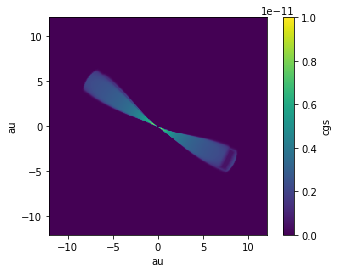

In [189]:
nch = 53
results.show_channelmap(0, nch, clim=(0, cmax), unit='cgs')

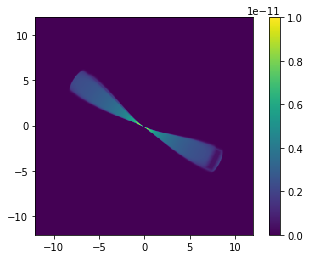

In [190]:
X = ( np.arange(Nx) - Nx/2) * Rmax/au * 2 / Nx
XX, YY = np.meshgrid(X, X)
plt.pcolormesh(XX, YY, cube[nch],  shading='auto')
plt.clim((0, cmax))
plt.colorbar()

plt.gca().set_aspect('equal')

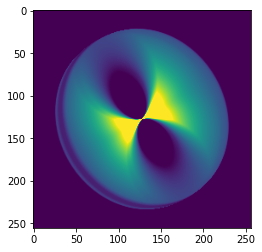

In [191]:
plt.imshow(np.sum(cube,axis=0)[::-1, ::-1])
plt.clim(0, 1e-10)

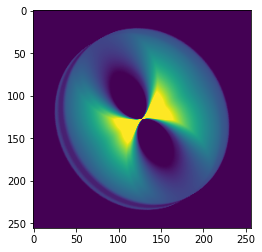

In [192]:
plt.imshow(np.sum(results.cube(0)[2], axis=0))
plt.clim(0, 1e-10)

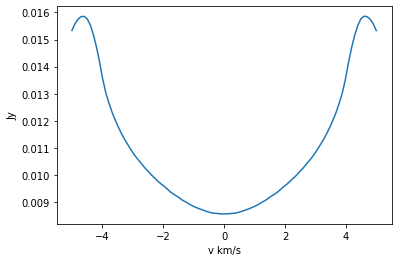

In [193]:
v1, F1 = results.show_spectrum(0)

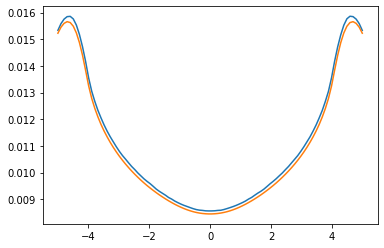

In [194]:
plt.plot(v1, F1)

dxy = np.deg2rad( Rmax/au * 2 / Nx / D /3600)
fac = dxy**2 * 1e23

F2 = np.sum(cube, axis=(1,2)) * fac
plt.plot(v1, F2)

#plt.yscale('log')

#plt.ylim(1e-4, 1)

(-5.0, 5.0)

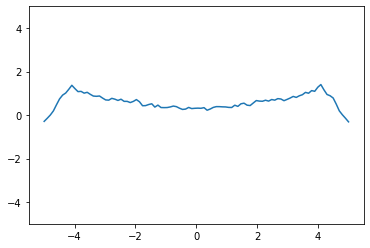

In [195]:
plt.plot(v1, (F1*0.99-F2)/(F2)*100)
plt.ylim(-5, 5)